<h1>Cool Maths</h1>

<h2>Local Expensive Min</h2>
<h3>Libraries</h3>

In [101]:
import numpy as np
import matplotlib as mlt
import matplotlib.pyplot as plt
from pprint import pprint
import asyncio
import scipy
from collections.abc import Iterable
import math
import bisect
from IPython import display
from IPython.display import HTML
from numpy.polynomial import Polynomial
from matplotlib import gridspec
from matplotlib.animation import FuncAnimation
from matplotlib.animation import HTMLWriter

from scipy import optimize as opt
from scipy.interpolate import splrep, splev, interp1d, CubicSpline

%reload_ext blackcellmagic


<h3>Functions</h3>

In [129]:
def f(x):
    return np.sin(x) + 0.05 * x ** 2
    

def slow(x):
    #await asyncio.sleep(0.01)
    y = f(x)
    return y + np.random.normal(0, 0.2, size=np.size(y))


def fit(X, Y):
    if X.size == 2:
        return Polynomial.fit(X, Y, deg=1)
    if X.size == 3:
        return Polynomial.fit(X, Y, deg=2)
    spl = splrep(X, Y, s = len(X)**2/250)
    return lambda x: splev(x, spl)


async def uncertainty(fit, limits, X, x):
    async def height(fit, limits, x=None):
        if x is None:
            x = np.linspace(*limits, 50)
        y = -fit(x)
        y -= y.min()
        y /= y.max()
        return y + 0.01

    async def sparcity(fit, limits, X, x=None):
        if x is None:
            x = np.linspace(*limits, 50)
        prob = np.zeros_like(x)
        for j, point in enumerate(x):
            prob[j] = np.min(np.abs(X-point))
        return prob

    probY = height(approx, limits, x)
    probX = sparcity(approx, limits, X, x)
    return await (probY) * await (probX)

    


This Method = -1.3744146133503963
fminbound with same number of iterations = [-1.88965833]
fminbound with 500 iterations max = -1.4275504909983434


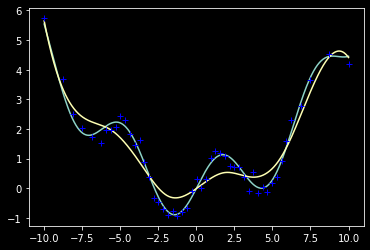

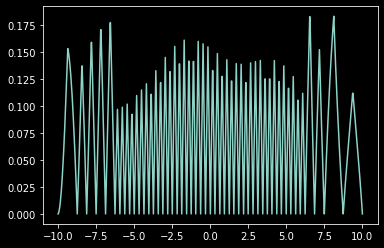

In [130]:
limits = np.array([-10, 10], dtype=float)
line = None
funIt = 50
x = np.linspace(*limits, 1000)
plt.figure(0)

plt.plot(x, f(x))

X = limits #- (limits-np.mean(limits))/4
Y = slow(X)
xs = np.zeros([funIt-2, len(x)])
ys = np.zeros([funIt-2, len(x)])

for i in range(funIt-2):
    approx = fit(X, Y)
    error = await uncertainty(fit, limits, X, x)
    nxt = np.argmax(error)

    index = bisect.bisect(X, x[nxt])
    X = np.insert(X, index, x[nxt])
    Y = np.insert(Y, index, slow(x[nxt]))
    
    xs[i,:] = x
    ys[i,:] = approx(x)
    
approx = fit(X, Y)
error = await uncertainty(approx, limits, X, x)
plt.figure(0)
plt.plot(x, approx(x))
plt.figure(0)
plt.plot(X, Y, "b+")
plt.figure(1)
plt.plot(x, error)
midLim = min(len(x)-2, max(np.argmin(approx(x)),1))
lims = [x[midLim - 1], x[midLim + 1]]
print(f"This Method = {opt.fminbound(approx,  *lims, maxfun=1000, disp = 0)}")
print(f"fminbound with same number of iterations = {opt.fminbound(slow, *limits, disp = 0, maxfun = funIt)}")
midLim = min(len(x)-2, max(np.argmin(f(x)),1))
lims = [x[midLim - 1], x[midLim + 1]]
print(f"fminbound with 500 iterations max = {opt.fminbound(f, *lims, disp = 0)}")


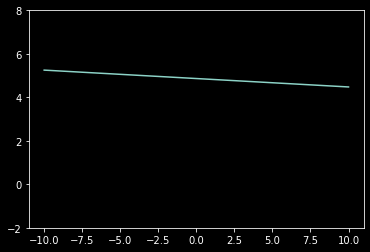

In [491]:
Figure = plt.figure()
lines_plotted = plt.plot([])
line_plotted = lines_plotted[0]
plt.xlim([-11, 11])
plt.ylim((-2, 8))
pltName = "optimiser.html"

def createGif(frame, x, y):
    line_plotted.set_data((x[frame,:], y[frame,:]))


anim_created = FuncAnimation(
    Figure, lambda i: createGif(i, xs, ys), frames=funIt-2)

writer = HTMLWriter(fps = 2)
anim_created.save(pltName, writer=writer)
HTML(pltName)


In [131]:
trueValue = -1.42755177897199
size = [15, 50]
epsilon_linspace = np.zeros(size)
epsilon_fmin = np.zeros(size)
epsilon_aLearning = np.zeros(size)
x = np.linspace(*limits, 1000)

for j in range(size[1]):
    for s in range(2,size[0]):
        _X = limits
        _Y = slow(_X)
        for i in range(2,s):
            _approx = fit(_X, _Y)
            _error = await uncertainty(fit, limits, _X, x)
            _nxt = np.argmax(_error)
            _index = bisect.bisect(_X, x[_nxt])
            _X = np.insert(_X, _index, x[_nxt])
            _Y = np.insert(_Y, _index, slow(x[_nxt]))
        _approx = fit(_X, _Y)
        _index = min(max(1, np.argmin(_approx(x))), len(x)-2)
        epsilon_aLearning[s, j] = opt.fminbound(_approx, x[_index-1], x[_index+1], maxfun=1000, disp =0) - trueValue
        print(f"\r{j,s}", end="")

for j in range(size[1]):
    for i in range(2, size[0]+2):
        xbar = np.linspace(*limits, i)
        epsilon_linspace[i-2, j] = xbar[np.argmin(slow(xbar))] - trueValue
        epsilon_fmin[i-2, j] = opt.fminbound(slow, *limits, disp=0, maxfun=i) - trueValue


(49, 14)

In [109]:
np.savetxt('epsilon_fmin.csv',epsilon_fmin)
np.savetxt('epsilon_aLearning.csv',epsilon_aLearning)
np.savetxt('epsilon_linspace.csv',epsilon_linspace)


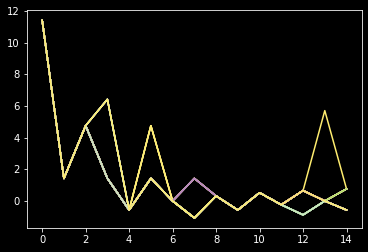

In [110]:
plt.plot(epsilon_linspace)

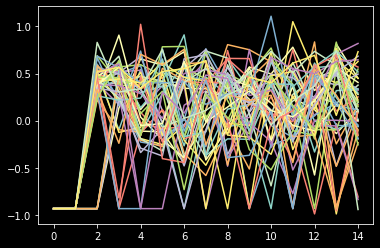

In [111]:
plt.plot(epsilon_fmin)

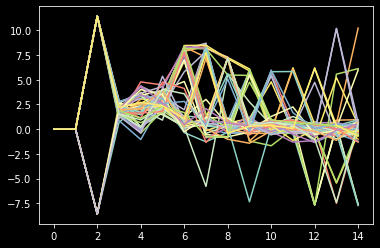

In [128]:
plt.plot(epsilon_aLearning)

(49, 16)

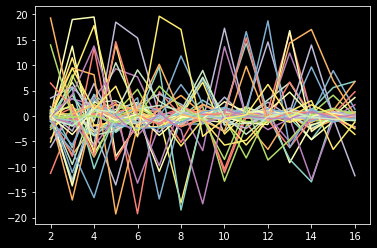

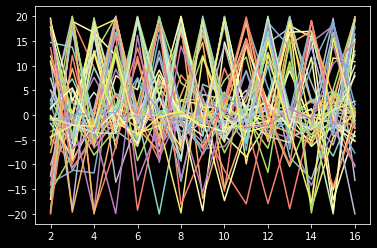

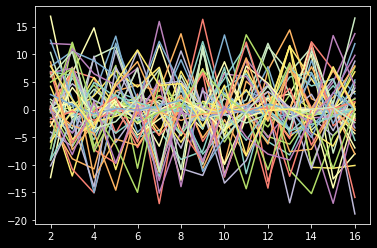

In [136]:

def randFunc():
    lims = [-10, 10]
    derivatives = 1
    interval = np.linspace(*lims, 5000)
    f = np.zeros([derivatives+1, len(interval)])
    f[-1,:] = np.random.uniform(-(derivatives+1)**2, (derivatives+1)**2, np.shape(interval))
    for i in range(1, derivatives):
        f[i, 0] = np.random.uniform(-1, 1)

    for i in range(1, len(interval)):
        for j in range(derivatives):
            f[j, i] = f[j, i-1] + f[j+1, i-1]*(interval[1] - interval[0])
    return interp1d(interval, f[0, :])

size = [15, 50]
epsilon_linspace = np.zeros(size)
epsilon_fmin = np.zeros(size)
epsilon_aLearning = np.zeros(size)
x = np.linspace(*limits, 1000)

for j in range(size[1]):
    for s in range(2,size[0]+2):
        _X = limits
        _Y = slow(_X)
        #############################################################
        newf = randFunc()
        f = lambda x: newf(x)
        slow = lambda x: f(x) + np.random.normal(0, 0.04, np.size(x))
        elim = np.linspace(-10, 10, 5000)
        trueValue = elim[np.argmin(f(elim))]
        ##############################################################
        for i in range(2,s):
            _approx = fit(_X, _Y)
            _error = await uncertainty(fit, limits, _X, x)
            _nxt = np.argmax(_error)
            _index = bisect.bisect(_X, x[_nxt])
            _X = np.insert(_X, _index, x[_nxt])
            _Y = np.insert(_Y, _index, slow(x[_nxt]))
        _approx = fit(_X, _Y)
        _index = min(max(1, np.argmin(_approx(x))), len(x)-2)
        epsilon_aLearning[s-2, j] = opt.fminbound(_approx, x[_index-1], x[_index+1], maxfun=1000, disp =0) - trueValue
        
        xbar = np.linspace(*limits, i)
        epsilon_linspace[s-2, j] = xbar[np.argmin(slow(xbar))] - trueValue
        epsilon_fmin[s-2, j] = opt.fminbound(slow, *limits, disp=0, maxfun=i) - trueValue
        print(f"\r{j,s}", end="")

ints = [i for i in range(2, size[0]+2)]
plt.figure(0)
plt.plot(ints, epsilon_linspace)
plt.figure(1)
plt.plot(ints, epsilon_aLearning)
plt.figure(2)
plt.plot(ints, epsilon_fmin)

